In [1]:
import torch
import torch.nn.functional as F
import pandas as pd
import matplotlib.pylab as plt
import numpy as np

In [63]:
class GECO():

    def __init__(self,
                goal_fri = 0.08,
                goal_seg = 0.02,
                alpha = 0.9,
                beta = 0.9,
                step_size = 0.01,
                lambda_s = 1.0,
                lambda_f = 1.0,
                speedup = 10,
                beta_min = 1e-10,
                beta_max = 1e10
                ):
        
        
        self.goal_fri = torch.tensor(goal_fri)  
        self.goal_seg = torch.tensor(goal_seg)  
        self.alpha = torch.tensor(alpha)
        self.beta = torch.tensor(beta)
        self.step_size = torch.tensor(step_size)
        self.lambda_s = torch.tensor(lambda_s)
        self.lambda_f = torch.tensor(lambda_f)
        self.speedup = torch.tensor(speedup)
        self.beta_min = torch.tensor(beta_min)
        self.beta_max = torch.tensor(beta_max)
        
        self.history_lambda_s = []
        
        # Initialize EMA values
        self.ema_seg = None
        self.ema_fri = None

    def loss(self, loss_fri, loss_seg, kl_loss):
        
        
        total_loss = self.lambda_s * loss_seg + self.lambda_f * loss_fri + kl_loss

        
        with torch.no_grad():
            
            if self.ema_seg is None:
                self.ema_seg = loss_seg.item()
                self.ema_fri = loss_fri.item()
            else:
                self.ema_seg = self.alpha * self.ema_seg + (1 - self.alpha) * loss_seg.item()
                self.ema_fri = self.beta * self.ema_fri + (1 - self.beta) * loss_fri.item()
        

            # Compute constraints
            C_seg = self.goal_seg - self.ema_seg
            C_fri = self.goal_fri - self.ema_fri
            
            
            if self.speedup is not None and C_seg > 0:
                self.lambda_s *= torch.exp(self.speedup * -C_seg * self.step_size)
            else:
                factor = torch.exp(-C_seg * self.step_size)
                self.lambda_s = (factor * self.lambda_s).clamp(self.beta_min, self.beta_max)


            if self.speedup is not None and C_fri > 0:
                self.lambda_f *= torch.exp(self.speedup * -C_fri * self.step_size)
            else:
                factor = torch.exp(-C_fri * self.step_size)
                self.lambda_f = (factor * self.lambda_f).clamp(self.beta_min, self.beta_max)
                
        print(f"Loss: {total_loss.item():.4f}, Lambda_s: {self.lambda_s:.4f}, Lambda_f: {self.lambda_f:.4f}")
        self.history_lambda_s.append(self.lambda_s)

        return total_loss, self.lambda_s, self.lambda_f

In [15]:
reco_loss = pd.read_csv("reco_loss.csv")["NewLossTest2 - Reconstruction training loss"].values
reg_loss = pd.read_csv("reg_loss.csv")["NewLossTest2 - Regression training loss"].values
kl_loss = pd.read_csv("kl_loss.csv")["NewLossTest2 - KL training loss"].values
total_loss_old = pd.read_csv("total_loss.csv")["NewLossTest2 - Total training loss__MIN"].values

In [59]:
reco_error = np.arange(1, 200, 1)
reco_loss = (np.exp((-175+reco_error[::-1])/25))
# reco_loss[50] = 100

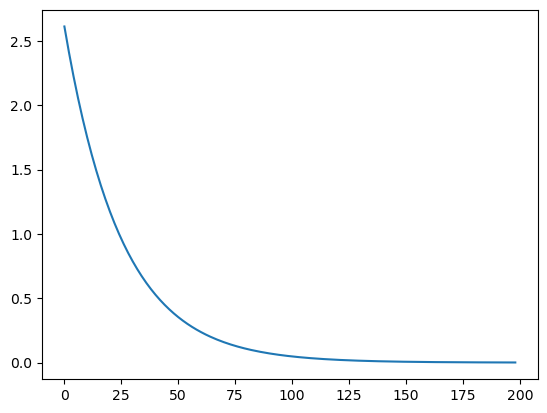

In [60]:
plt.plot(reco_loss)

In [90]:
geco = GECO(
        goal_fri = 0.08,
        goal_seg = 0.2,
        alpha = 0.9,
        beta = 0.9,
        step_size = 0.01,
        lambda_s = 1.0,
        lambda_f = 1.0,
        speedup = 10,
        beta_min = 1e-10,
        beta_max = 1e10
)
reco_error = []
for i in np.arange(1, 200, 1)[::-1]:
    reco_error.append(np.exp((-175+i)/25))
    print(reco_error[-1])
    if i < 75:
        reco_error[-1] = 1
    print(reco_error[-1])
    geco.loss(loss_fri = torch.tensor(0.01), loss_seg = torch.tensor(reco_error[-1]), kl_loss = 0.0001)

2.611696473423118
2.611696473423118
Loss: 2.6218, Lambda_s: 1.0244, Lambda_f: 0.9930
2.509290389936298
2.509290389936298
Loss: 2.5806, Lambda_s: 1.0493, Lambda_f: 0.9861
2.4108997064172097
2.4108997064172097
Loss: 2.5397, Lambda_s: 1.0746, Lambda_f: 0.9792
2.3163669767810915
2.3163669767810915
Loss: 2.4991, Lambda_s: 1.1002, Lambda_f: 0.9724
2.225540928492468
2.225540928492468
Loss: 2.4584, Lambda_s: 1.1261, Lambda_f: 0.9656
2.1382762204968184
2.1382762204968184
Loss: 2.4176, Lambda_s: 1.1521, Lambda_f: 0.9589
2.0544332106438876
2.0544332106438876
Loss: 2.3766, Lambda_s: 1.1782, Lambda_f: 0.9522
1.9738777322304477
1.9738777322304477
Loss: 2.3353, Lambda_s: 1.2044, Lambda_f: 0.9455
1.8964808793049515
1.8964808793049515
Loss: 2.2936, Lambda_s: 1.2305, Lambda_f: 0.9389
1.8221188003905089
1.8221188003905089
Loss: 2.2515, Lambda_s: 1.2565, Lambda_f: 0.9324
1.7506725002961012
1.7506725002961012
Loss: 2.2091, Lambda_s: 1.2824, Lambda_f: 0.9259
1.6820276496988864
1.6820276496988864
Loss: 2.166

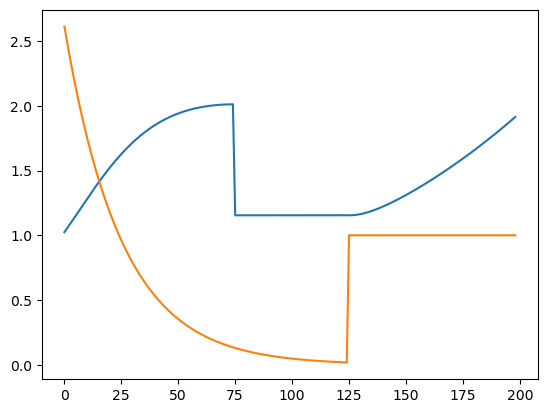

In [91]:
plt.plot(geco.history_lambda_s)
plt.plot(reco_error)

for rec, reg, kl in zip(torch.arange(5.1, 6, 0.01), torch.arange(0.07, 1.5, 0.01), torch.arange(0.07, 1.5, 0.01)):
    loss, s, f = geco.loss(reg, rec, kl)


total_loss = []
lambda_s = []
lambda_f = []
for rec, reg, kl in zip(reco_loss, reg_loss, kl_loss):
    loss, s, f = geco.loss(reg, rec, kl)
    total_loss += [loss]
    lambda_s += [s]
    lambda_f += [f]

fig, axs = plt.subplots(3, 2, figsize=(20, 20))

plt.rcParams.update({'font.size': 14})

# Plot on the first subplot
axs[0, 0].plot(lambda_s)
axs[0, 0].set_title('Lambda segmentation')
axs[0, 0].set_xlabel('epochs')
axs[0, 0].set_ylabel('Lambda_s')
axs[0, 0].legend()

# Plot on the second subplot
axs[0, 1].plot(lambda_f)
axs[0, 1].set_title('Lambda friction')
axs[0, 1].set_xlabel('epochs')
axs[0, 1].set_ylabel('Lambda_f')
axs[0, 1].legend()


axs[1, 0].plot(reco_loss)
axs[1, 0].set_title('Total loss')
axs[1, 0].set_xlabel('epochs')
axs[1, 0].set_ylabel('Total loss')
axs[1, 0].legend()


# axs[1, 1].plot(reco_loss)
# axs[1, 1].set_title('Recon loss')
# axs[1, 1].set_xlabel('epochs')
# axs[1, 1].set_ylabel('Recon loss')
# axs[1, 1].legend()

# axs[2, 0].plot(total_loss)
# axs[2, 0].plot(total_loss_old)
# axs[2, 0].set_title('Total loss')
# axs[2, 0].set_xlabel('epochs')
# axs[2, 0].set_ylabel('Total loss')
# axs[2, 0].legend()


plt.tight_layout()